# Demo of `columnsfmri` 
## Simulation and optimization of fMRI of cortical columns

Import model implementation from columnsfmri.py and other useful modules.

In [22]:
import columnsfmri

%matplotlib inline
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import importlib
importlib.reload(columnsfmri)

<module 'columnsfmri' from '/Users/denis/Documents/Projects/currentProjects/columnsfmri/columnsfmri.py'>

### A tour of the inner workings of the model

Inititialize simulation using a 512 x 512 grid on an area of 24 x 24 mm. 

In [23]:
N = 512; L = 24
sim = columnsfmri.simulation(N,L)

Simulate a column pattern by filtering Gaussian white noise. Rho is the main pattern frequency, delta specifies the amount of irregularity.

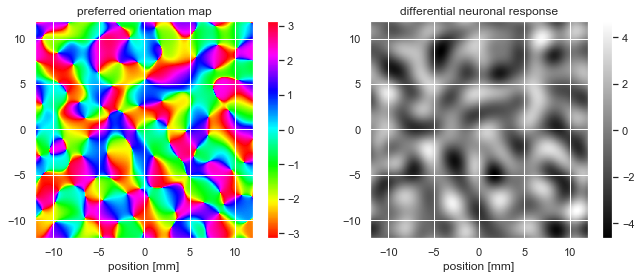

In [28]:
gwn = sim.gwnoise()
rho,deltaRelative = 0.2,1
columnPattern,preferrenceMap = sim.columnPattern(rho,deltaRelative,gwn)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(preferrenceMap,'hsv',title='preferred orientation map',ax=axes[0])
sim.plotPattern(columnPattern,title='differential neuronal response',ax=axes[1])

Simulate a differential spatial BOLD response with a FWHM of 2 mm, and a corresponding single condition average response amplitude of 5%.

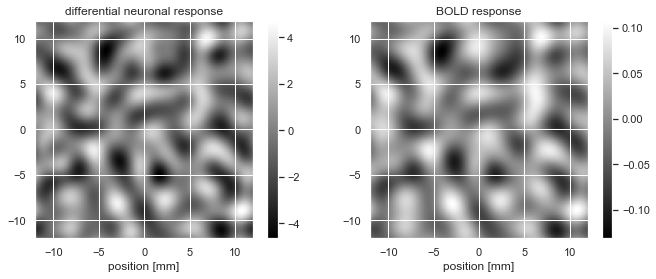

In [32]:
fwhm = 2
beta = 0.05
boldPattern,_,_ = sim.bold(fwhm,beta,columnPattern)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(columnPattern,title='differential neuronal response',ax=axes[0])
sim.plotPattern(boldPattern,title='BOLD response',ax=axes[1])

Simulate MRI sampling using a voxel width of 3 mm. (We first add the relative response pattern to a constant background of 1).

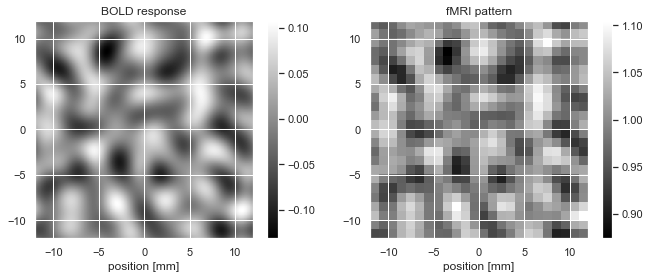

In [33]:
w = 1
mriPattern = sim.mri(w,1+boldPattern)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(boldPattern,title='BOLD response',ax=axes[0])
sim.plotPattern(mriPattern,title='fMRI pattern',ax=axes[1])

The amount of functional contrast _c_ can be quantified as the standard deviation of the imaged responses (contrast range).

In [39]:
c = np.std(mriPattern)
print('c = %.2f%%' % (100*c))

c = 4.30%


Simulate the noise level as a function of voxel width.

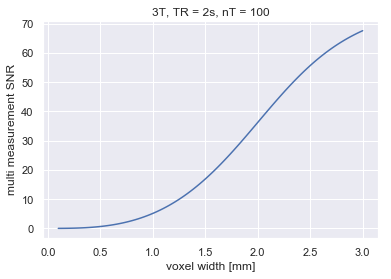

In [36]:
w = np.linspace(0.1,3,100)
V = w**3
TR = 2
nT = 1
differentialFlag = True
noiseType = '3T'
SNR = 1/columnsfmri.noiseModel(V,TR,nT,differentialFlag,noiseType=noiseType)

plt.plot(w,SNR)
plt.xlabel('voxel width [mm]')
plt.ylabel('multi measurement SNR')
plt.title('3T, TR = 2s, nT = 100')
plt.show()

SNR for a voxel width of 2 mm:

In [40]:
w = 2
V = w**3
SNR = 1/columnsfmri.noiseModel(V,TR,nT,differentialFlag,noiseType=noiseType)
print('SNR = %.2f' % SNR)

SNR = 36.24


Contrast to noise ratio = c * SNR:

In [41]:
CNR = c * SNR
print('CNR = %.2f' % CNR)

CNR = 1.56


Calculate detection probability from CNR and number of voxels.

In [42]:
CNR = 1
nVoxels = 10
p = columnsfmri.detectionProbability(CNR,nVoxels)
print('p = %.2f%%' % (100*p))

p = 51.76%


Add noise to MRI pattern:

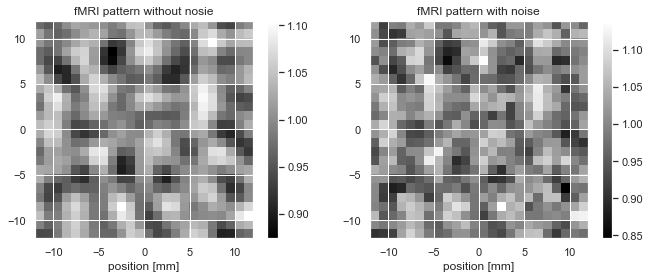

In [44]:
 mriPlusNoisePattern = mriPattern + \
    (1/SNR) * np.random.randn(*mriPattern.shape)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(mriPattern,title='fMRI pattern without nosie',ax=axes[0])
sim.plotPattern(mriPlusNoisePattern,title='fMRI pattern with noise',ax=axes[1])

Calculate the correlation between the original and the (interpolated) imaged pattern.

In [45]:
R = sim.patternCorrelation(columnPattern,mriPlusNoisePattern)
print('R = %.2f' % R)

R = 0.81


### Run optimization simulation

Set standard parameters for optimization simulation.

In [13]:
parameters = columnsfmri.setParameters('irregular')
for parameter,value in parameters.items():
    print(parameter + ": " + str(value))

randomNumberSeed: 23
nTrials: 32
N: 512
L: 24
wRange: [4.         3.         2.4        2.         1.71428571 1.5
 1.33333333 1.2        1.09090909 1.         0.92307692 0.85714286
 0.8        0.75       0.70588235 0.66666667 0.63157895 0.6
 0.57142857 0.54545455 0.52173913 0.5        0.48       0.46153846
 0.44444444 0.42857143 0.4        0.375      0.35294118 0.32432432
 0.3        0.27272727 0.25       0.22641509 0.2        0.17391304
 0.15       0.125      0.1        0.075      0.05      ]
rho: 0.625
deltaRelative: 1
fwhm: 1.02
beta: 0.035
sliceThickness: 2.5
AFlat: 87
TR: 2
nT: 1000
noiseType: 7T


Run optimization simulation:

In [14]:
results = columnsfmri.simulatefMRIOfColumnPatterns(parameters)

Summarize results:

In [15]:
columnsfmri.printResults(results)

optimized quantity                 | optimal value | optimal voxel width
-----------------------------------+---------------+--------------------
univariate detection probability   | 0.54          | 1.09 mm            
multivariate detection probability | 1.00          | 0.92 mm            
decoding probability - 2 classes   | 1.00          | 0.92 mm            
decoding accuracy    - 2 classes   | 0.99          | 0.92 mm            
decoding probability - 4 classes   | 1.00          | 0.92 mm            
decoding accuracy    - 4 classes   | 0.82          | 0.92 mm            
decoding probability - 8 classes   | 1.00          | 0.92 mm            
decoding accuracy    - 8 classes   | 0.39          | 0.92 mm            
pattern correlation                | 0.67          | 0.63 mm            


Plot results:

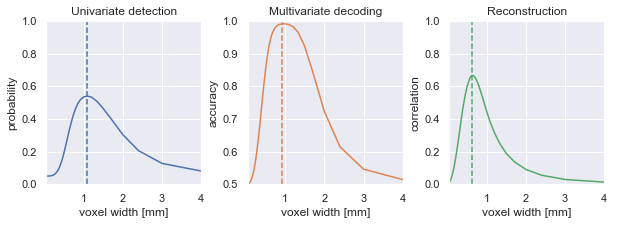

In [16]:
columnsfmri.displayFigureA(results)